# Previsão de series temporais com Prophet

Neste projeto irei trabalhar com series temporais, fazendo análises e previsões com a ferramenta Prophet. O dataset será de um centro de adoções e irei trabalhar com a saída dos animais (outcome).

## Prophet e Series Temporais

Prophet é uma ferramenta de *Forecasting* de series temporais, utilizada pelo Facebook, ela trabalha bem com tendências e sazonalidades além de feriados (inclusive alguns feriados brasileiros).

Series temporais são um assunto complicado de entender todos seus aspectos, fazer previsões com outras ferramentas ou até utilizando modelos matemáticos e estatísticos é difícil e requer um maior conhecimento. O Prophet vem para tentar facilitar isso, sendo possível fazer ajustes para encaixar em quase todos os problemas. Para conhecer mais basta [acessar sua pagina](https://facebook.github.io/prophet/).

## Abrigo de animais

Segundo diz em seu site: Austin Animal Center (Texas) provê abrigo para mais de 16.000 animais anualmente além de proteção para animais e serviços para animais de estimação em Austin e outras partes de Travis County. Aceitando e cuidando de qualquer animal independente da idade, estado de saúde, espécie ou raça.

Tendo como principal objetivo "destinar todos os animais possíveis para um novo lar, seja por meio de adoção, assistência social ou grupos de resgate."

Uma das missões do abrigo é que até 90% dos animais recebam um lar

Para ler mais sobre acesse o site do [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center).

## Projeto e Dados

Neste projeto, irei analisar as saídas dos animais (adoções e retorno aos donos). Com essa análise, espera-se que sejamos capazes de identificar um padrão.

Além disso pode-se fazer outros tipos de análises capazes de ajudar o centro de adoção como:

- Planejar compras de insumos (remédios, comida, etc);
- Contratação de funcionários e colaboradores;
- Fazer campanhas visando otimizar a adoção de animais.

Os dados foram disponibilizados pelo Austin Animal Center e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O dataset usado neste notebook foi atualizado em 9 de Março de 2021 e contém **124580 linhas** e **12 colunas**.

In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [2]:
# importando os dados para um dataframe
df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

# convertendo a coluna DateTime para o formato de data
df.DateTime = pd.to_datetime(df.DateTime)

# ver primeiras entradas 
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,2020-08-16 11:38:00,08/16/2020 11:38:00 AM,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


## Análise Exploratória

Primeiramente podemos avaliar que existem alguns valores faltantes, nada que possa atrapalhar nossas análises já que são os de nome dos animais (Name), apenas 20 de saída (Outcome Type) e os outros de subtipo de saída (Outcome Subtype).

In [3]:
# verificar valores nulos
df.isnull().sum()

Animal ID               0
Name                39050
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           20
Outcome Subtype     67219
Animal Type             0
Sex upon Outcome        1
Age upon Outcome        0
Breed                   0
Color                   0
dtype: int64

Visualizando as saídas dos animais (Outcome Type) é possivel ver que mesmo com a soma de adotados (Adoption) e retornados aos donos (Return to Owner), não se chega a 90% de animais com um lar, inclusive a porcentagem de eutanasias (Euthanasia) chega a quase 7%, um número relativamente alto se levarmos em conta que devemos tentar encontrar um lar para o maior número de animais possíveis.

In [4]:
# porcentagem da saída de animais
df['Outcome Type'].value_counts(normalize=True)

Adoption           0.444629
Transfer           0.294918
Return to Owner    0.172824
Euthanasia         0.067413
Died               0.009281
Rto-Adopt          0.005628
Disposal           0.004568
Missing            0.000562
Relocate           0.000177
Name: Outcome Type, dtype: float64

Outra coisa que se pode notar é que cahorros são a maioria dos animais com 56%, os gatos vem logo atrás com 37%, inclusive que eles aceitam realmente qualquer animal.

In [5]:
# porcentagem do tipo de animais
df['Animal Type'].value_counts(normalize=True)

Dog          0.566431
Cat          0.375550
Other        0.053163
Bird         0.004696
Livestock    0.000161
Name: Animal Type, dtype: float64

Cerca de 67% dos animais são castrados, lembrando que o abrigo tem açôes para castração de animais de graça.

In [6]:
# porcentagem sexo e castração de animais
df['Sex upon Outcome'].value_counts(normalize=True)

Neutered Male    0.351753
Spayed Female    0.316153
Intact Male      0.126803
Intact Female    0.123127
Unknown          0.082165
Name: Sex upon Outcome, dtype: float64

A "raça" que mais aparece no abrigo seria vira-latas de pelos curtos.

In [7]:
# porcentagem raça dos animais
df['Breed'].value_counts(normalize=True).head()

Domestic Shorthair Mix     0.251509
Pit Bull Mix               0.067908
Domestic Shorthair         0.055555
Labrador Retriever Mix     0.055306
Chihuahua Shorthair Mix    0.050345
Name: Breed, dtype: float64

Criei uma nova coluna chamada "count", onde irei colocar uma contagem para aqueles animais que foram adotados ou retornados aos seus donos, com isso poderei fazer outras análises além de já preparar os dados para series temporais.

In [8]:
# criando nova coluna na tabela
df['count'] = 0
df.loc[(df['Outcome Type'] == 'Adoption') | (df['Outcome Type'] == 'Return to Owner'), 'count'] = 1

Aqui podemos ver que além de ser os que mais estão presentes no abrigo os cães são também os que mais são adotados, cerca de 74% foram adotados. Enquanto gatos apenas 50%.

In [9]:
# agrupando tipo de animal e contagem de adoções
df.groupby(['Animal Type'])['count'].sum() / df.groupby(['Animal Type'])['count'].count()

Animal Type
Bird         0.406838
Cat          0.504766
Dog          0.743644
Livestock    0.600000
Other        0.085762
Name: count, dtype: float64

Até aqui é possivel avaliar que existe uma demanda maior por adotar cães, e que eles são maioria no abrigo também. os animais em sua maioria são castrados e são vira-latas.

Sobre arrumar lar para 90% dos animais, ainda não chegaram nesse número mas vamos analisar as series temporais e ver o que pode ser feito.

## Análise Series Temporais

Para fazer algumas análises de series temporais, primeiramente irei colocar em um novo dataframe a coluna com as datas e a coluna que criei que 1 significa que o animal foi adotado e 0 que não.

In [10]:
# criando novo dataframe com "DateTime" e "count" apenas
adoptions_df = df[['DateTime', 'count']]

adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,count
DateTime,
2013-10-01 09:31:00,1
2013-10-01 10:39:00,0
2013-10-01 10:44:00,0
2013-10-01 10:44:00,0
2013-10-01 11:03:00,1


Os dados vão de 10 de Outubro de 2013 até 08 de Março de 2021.

In [11]:
# data inicial e data final do dataset
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2021-03-08 12:09:00'))

Separando as adoções por ano podemos enxargar a queda que houve no ano de 2020, a pandemia do Covid-19 pode ter influênciado muito nas adoções.

In [12]:
# novo dataframe para análise de quantide de adoções por ano
df_ano = {'Ano': ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'],
          'Adotados': [adoptions_df['2013'].sum()[0], adoptions_df['2014'].sum()[0], adoptions_df['2015'].sum()[0],
                       adoptions_df['2016'].sum()[0], adoptions_df['2017'].sum()[0], adoptions_df['2018'].sum()[0],
                       adoptions_df['2019'].sum()[0], adoptions_df['2020'].sum()[0], adoptions_df['2021'].sum()[0]]}

df_ano = pd.DataFrame(df_ano)
df_ano

,Ano,Adotados
0,2013,2589
1,2014,10433
2,2015,10882
3,2016,11378
4,2017,11318
5,2018,10890
6,2019,12381
7,2020,6226
8,2021,813


No ano de 2019 havia um pico maior que dos outros anos mas as adoções cairam pela metade em 2020.

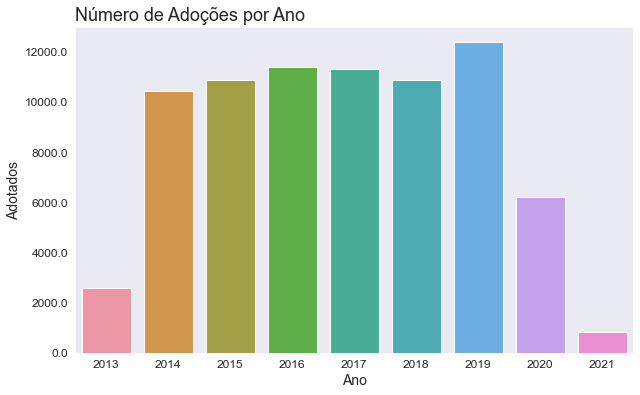

In [13]:
# estilo dos gráficos do seaborn
sns.set_palette('Accent')
sns.set_style('dark')

# gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df_ano.Ano, y=df_ano.Adotados);
ax.set_title('Número de Adoções por Ano', fontsize=18, loc='left');
ax.set_xlabel('Ano', fontsize=14)
ax.set_ylabel('Adotados', fontsize=14)
ax.set_xticklabels(df_ano.Ano, fontsize=12);
ax.set_yticklabels(ax.get_yticks(), fontsize=12);

Aqui nestes primeiros gráficos irei separar os dados por dias e por semanas, já que o fato de ter muitas adoções no mesmo dia em horários diferentes poderia atrapalhar a visualização.

É possível notar que tem diversos momentos onde a adoção de animais tem um pico maior, tambêm da para perceber que nos anos de pandemia houve claramente uma queda das adoções, como foi possivel ver no gráfico de barras anterior.

Text(0, 0.5, '')

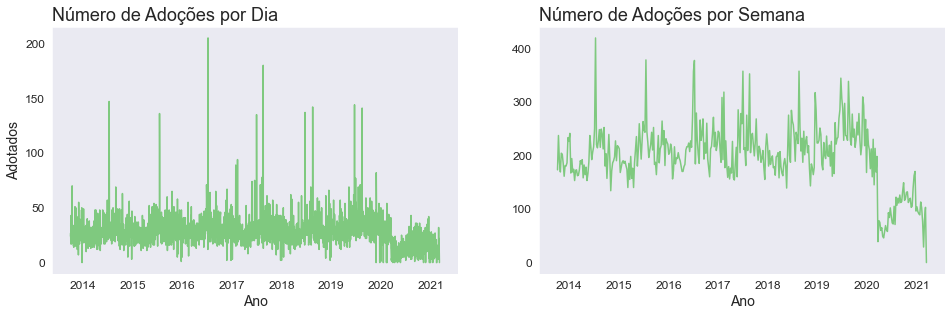

In [14]:
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

# gráficos de linha
plt.figure(figsize=(16, 10))
ax = plt.subplot(2, 2, 1)
ax = sns.lineplot(x=adoptions_df.resample('D').sum().index, y=adoptions_df.resample('D').sum()['count'])
ax.set_title('Número de Adoções por Dia', fontsize=18, loc='left');
ax.set_xlabel('Ano', fontsize=14)
ax.set_ylabel('Adotados', fontsize=14)


ax = plt.subplot(2, 2, 2)
ax = sns.lineplot(x=adoptions_df.resample('W').sum().index, y=adoptions_df.resample('W').sum()['count'])
ax.set_title('Número de Adoções por Semana', fontsize=18, loc='left');
ax.set_xlabel('Ano', fontsize=14)
ax.set_ylabel('', fontsize=14)

Em 2019 é possivel visualizar que as adoções tem um pico maior durante as férias de verão americana e seguia com um bom número de adoções até o final do ano.

Em 2020 tem a queda brusca com a pandemia, provavelmente houve problemas para o abrigo, já que teria que manter mais animais por mais tempo.

Text(0, 0.5, 'Adotados')

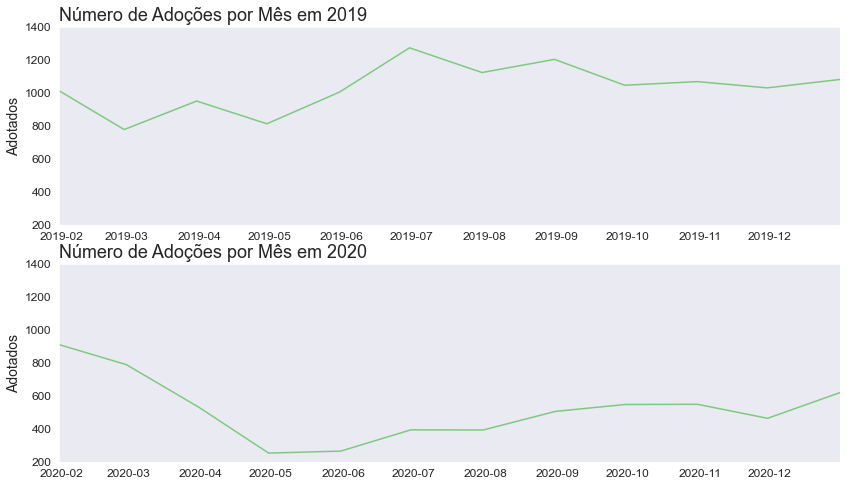

In [15]:
#Graficos de linha
ax = plt.figure(figsize=(14, 8))
ax = plt.subplot(2, 1, 1)
ax = sns.lineplot(x=adoptions_df['2019'].resample('M').sum().index, y=adoptions_df['2019'].resample('M').sum()['count'])
ax.set_xlim([adoptions_df['2019'].resample('M').sum().index.min(), adoptions_df['2019'].resample('M').sum().index.max()])
ax.set_ylim([200, 1400])
ax.set_title('Número de Adoções por Mês em 2019', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Adotados', fontsize=14)

ax = plt.subplot(2, 1, 2)
ax = sns.lineplot(x=adoptions_df['2020'].resample('M').sum().index, y=adoptions_df['2020'].resample('M').sum()['count'])
ax.set_xlim([adoptions_df['2020'].resample('M').sum().index.min(), adoptions_df['2020'].resample('M').sum().index.max()])
ax.set_ylim([200, 1400])
ax.set_title('Número de Adoções por Mês em 2020', fontsize=18, loc='left');
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Adotados', fontsize=14)

## Preparando dados e criando modelo de Forecasting

Para este modelo irei utilizar os dados diários, o Prophet nescessita que o dataframe tenha as colunas com nomes específicos, então primeiro retirei os dados do index e coloquei em uma coluna e depois renomiei as colunas para **ds** para as datas e **y** para os valores.

In [16]:
# trabalhar com dados diários
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime':'ds', 'count':'y'})

# ver as 5 primeiras entradas
prophet_df.head()

,ds,y
0,2013-10-01,24
1,2013-10-02,27
2,2013-10-03,17
3,2013-10-04,20
4,2013-10-05,43


In [17]:
# criando modelo do Prophet
model = Prophet(daily_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(prophet_df)

# determinar o período de dias para previsão
future = model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

Este gráfico mostra a previsão para o resto do ano de 2021 e o de inicio de 2022, como o Prophet não é capaz de saber que estamos em uma pandemia, ou quando ela pode acabar, ele segue mostrando a queda de adoções.

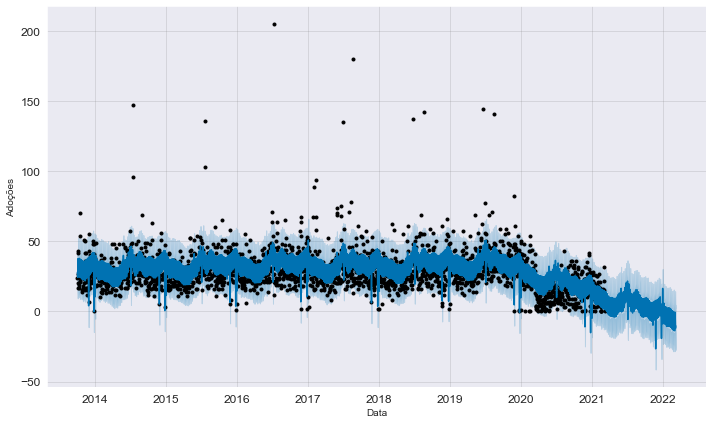

In [18]:
# visualizar o gráfico com as previsões
model.plot(forecast, xlabel='Data', ylabel='Adoções');

Separando os compomentes que compõe o modelo, podemos avaliar que:

- A tendência das adoções é realmente cair, como já havia caindo;
- São poucos os feriados em que o número de adoções aumentam, talvez os feriados onde se dão presentes, como o natal.
- Finais de semana e terça-feiras são os dias com mais adoções;
- E como visto antes, o mês de julho e o final do ano são os momentos onde tem mais adoções, por causa das férias e o natal;

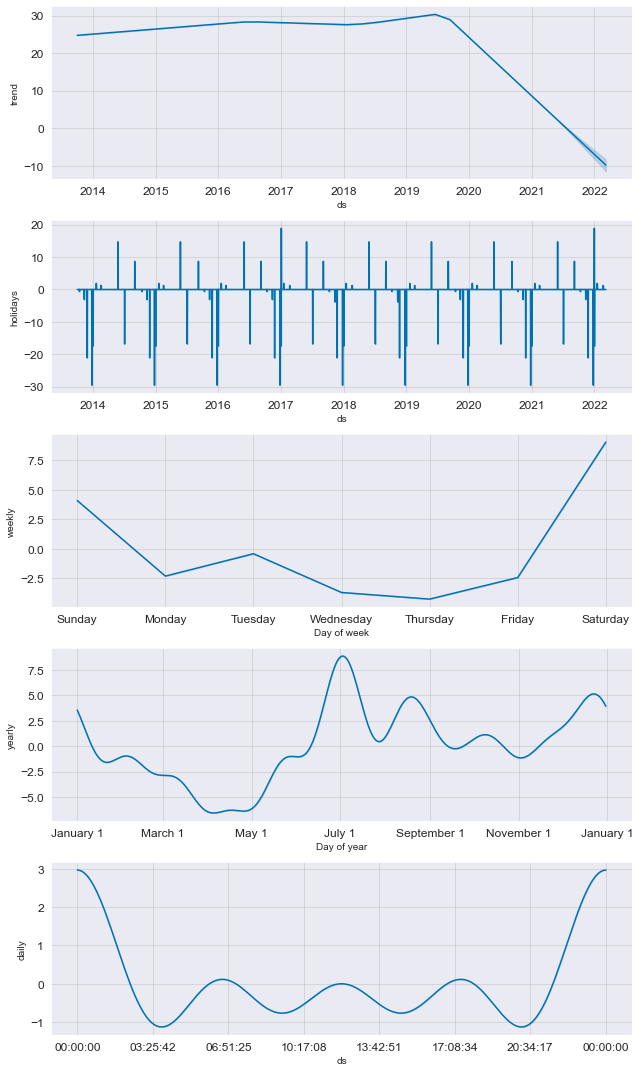

In [19]:
# separar os componentes do modelo
model.plot_components(forecast);

## Avaliação do Modelo

Irei agora avaliar o modelo do Prophet utilizando Cross Validation, a principal métrica utilizada será a MdAPE.

MdAPE calcula a Mediana Absoluta da Performance do Erro, entre o forecast e as saídas. Quanto mais proxímo de zero melhor.

Outra coisa a se notar é que a coluna **yhat** que aparece na tabela seria a previsão feita pelo modelo, enquanto o **y** é o valor verdadeiro.

In [20]:
# Validação cruzada do modelo
df_cv = cross_validation(model, horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2017-03-09 00:00:00 and 2020-03-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-10,25.938330,12.279249,38.620467,15,2017-03-09
1,2017-03-11,39.299757,26.265482,52.209387,25,2017-03-09
2,2017-03-12,37.401155,24.500098,49.452922,20,2017-03-09
3,2017-03-13,27.431031,14.486755,41.497195,24,2017-03-09
4,2017-03-14,28.107790,15.526900,39.744102,22,2017-03-09


Por fim a tabela com as métricas de erros, o MdAPE que vamos utilizar, está em torno de 22%, o que não é ruim mas também não é excelente, o fato de estar fazendo a previsão por dia aumenta esse valor, fazer uma previsão para menores periodos ou diferentes formas de agregar os dados como por semana ou mês, poderiam afetar um pouco esse valor e diminuir o erro.

In [21]:
# metricas de avaliação
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,118.839028,10.901331,8.278780,0.222375,0.827451
1,37 days 00:00:00,120.068383,10.957572,8.308426,0.222375,0.820588
2,37 days 12:00:00,120.451157,10.975024,8.321769,0.222375,0.819608
3,38 days 00:00:00,120.168308,10.962131,8.307453,0.222375,0.820588
4,38 days 12:00:00,119.393078,10.926714,8.262939,0.218229,0.823529


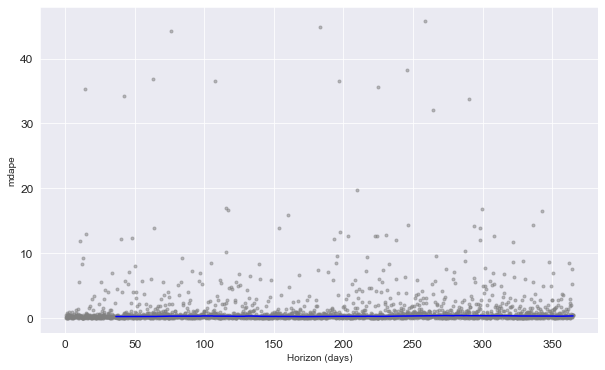

In [22]:
# gráfico da métrica de avaliação MdAPE
fig = plot_cross_validation_metric(df_cv, metric='mdape')